# Timsort vs Powersort

## Preliminaries

2023-03-20 Confirmed that the PyPy implementations of Timsort and Powersort
yield the same comparison counts as the CPython implementations.


NB: Careful, when checking this we need to run the sorting call of the list through the
instrumented cpython copies with print debug enabled, by then we have to run `run_information.py`
through the copy of cpython that does *not* print debug info
(as the rank reduction induces extra comparisons),
but we must use the correct sort implementation to get the correct comparison count.

But, long story short, we can use the following two implementations for our purposes,
as they yielded identical results.


In [1]:
%load_ext autoreload
%autoreload 2
import Support.Counters as Counters
import PyPySorters.listsort_powersort
import PyPySorters.listsort_timsort
import random

random.seed(2348905739)
A = list(range(10000))
random.shuffle(A)

C = [Counters.ComparisonCounter(x) for x in A]
print("Running Powersort")
Counters.reset_counters()
PyPySorters.listsort_powersort.sort(C)
Counters.print_counters()
C = [Counters.ComparisonCounter(x) for x in A]
print("Running Timsort")
Counters.reset_counters()
PyPySorters.listsort_timsort.sort(C)
Counters.print_counters()


Running Powersort
Comparisons: 119877
Eq Comparisons: 0
MergeCosts: 79760
Running Timsort
Comparisons: 119954
Eq Comparisons: 0
MergeCosts: 79840


## Experiments

Now for a more systematic approach.

### Init:

In [2]:
%load_ext autoreload
%autoreload 2
import random
import pandas as pd
import matplotlib.pylab as plt

import PyPySorters.listsort_powersort as powersort
import PyPySorters.listsort_timsort as timsort
import Support.Counters as Counters
import Inputs.Inputs as Inputs



def cost(lst, sorter):
    wrapped = [Counters.ComparisonCounter(x) for x in lst]
    Counters.reset_counters()
    sorter.sort(wrapped)
    assert Counters.ComparisonCounter.EQ_COMPARISONS == 0
    return {
        # 'algo': sorter.name(),
        'mc': Counters.MergeCosts.MERGECOST,
        'cmps': Counters.ComparisonCounter.COMPARISONS,
        'input-hash': hash(tuple(lst)),
    }


def differences(repetitions, input_generator):
    diffs = pd.DataFrame()
    for _ in range(repetitions):
        A = input_generator()
        ps = cost(A, powersort)
        ts = cost(A, timsort)
        diff = {}
        diff['algo'] = 'timsort-over-powersort'
        diff['mc'] = 1.0*ts['mc'] / ps['mc']
        diff['cmps'] = 1.0*ts['cmps'] / ps['cmps']
        diff['mc-diff'] = 1.0 * ts['mc'] - ps['mc']
        diff['cmps-diff'] = 1.0 * ts['cmps'] - ps['cmps']
        diff['mc-powersort'] = ps['mc']
        diff['cmps-powersort'] = ps['cmps']
        diff['input-hash'] = ps['input-hash']
        diffs = diffs.append(diff, ignore_index=True)
    return diffs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Random Permutations

For random permutations, not too much is saved,
but at least we hard do worse.


In [3]:
n = 10000
sqrtn = int(n ** 0.5)
reps = 200

RNG = random.Random(2348905734)
diffs = differences(reps, lambda: Inputs.random_permutation(n, RNG))
#print(diffs)
print(diffs['mc']  .describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))
print(diffs['cmps'].describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))

count    2.000000e+02
mean     1.001003e+00
std      2.226018e-16
min      1.001003e+00
1%       1.001003e+00
5%       1.001003e+00
10%      1.001003e+00
25%      1.001003e+00
50%      1.001003e+00
75%      1.001003e+00
max      1.001003e+00
Name: mc, dtype: float64
count    200.000000
mean       1.000666
std        0.000207
min        1.000134
1%         1.000233
5%         1.000350
10%        1.000401
25%        1.000526
50%        1.000651
75%        1.000803
max        1.001269
Name: cmps, dtype: float64


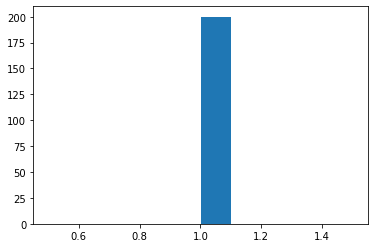

(array([ 4.,  8., 28., 31., 52., 31., 26., 11.,  7.,  2.]),
 array([1.00013354, 1.00024708, 1.00036061, 1.00047415, 1.00058769,
        1.00070122, 1.00081476, 1.0009283 , 1.00104183, 1.00115537,
        1.00126891]),
 <a list of 10 Patch objects>)

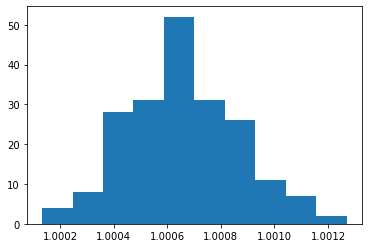

In [4]:
plt.hist(diffs['mc'])
plt.show()
plt.hist(diffs['cmps'])


### Expected $\sqrt n$ Random Runs

In [5]:
n = 10000
sqrtn = int(n ** 0.5)
reps = 200

RNG = random.Random(2348905734)
diffs = differences(reps, lambda: Inputs.random_runs(n, sqrtn, RNG))
print(diffs)
print(diffs['mc']  .describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))
print(diffs['cmps'].describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))

                       algo      cmps  cmps-diff  cmps-powersort  \
0    timsort-over-powersort  1.041240     3054.0         74054.0   
1    timsort-over-powersort  1.027431     2061.0         75134.0   
2    timsort-over-powersort  1.017574     1279.0         72777.0   
3    timsort-over-powersort  1.017495     1300.0         74309.0   
4    timsort-over-powersort  1.062275     4726.0         75889.0   
..                      ...       ...        ...             ...   
195  timsort-over-powersort  1.064602     4873.0         75431.0   
196  timsort-over-powersort  1.042946     3200.0         74513.0   
197  timsort-over-powersort  1.024837     1888.0         76016.0   
198  timsort-over-powersort  1.006901      506.0         73322.0   
199  timsort-over-powersort  1.032119     2423.0         75438.0   

       input-hash        mc  mc-diff  mc-powersort  
0    6.644946e+18  1.051520   3231.0       62713.0  
1    4.226510e+18  1.032988   2099.0       63630.0  
2   -7.853696e+18  1.012

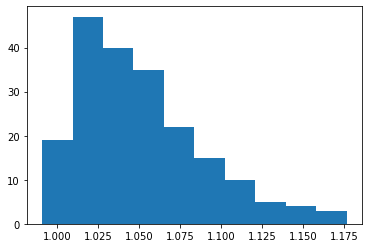

(array([21., 23., 44., 34., 28., 19., 12.,  8.,  5.,  6.]),
 array([0.99626307, 1.00550295, 1.01474282, 1.0239827 , 1.03322258,
        1.04246246, 1.05170234, 1.06094221, 1.07018209, 1.07942197,
        1.08866185]),
 <a list of 10 Patch objects>)

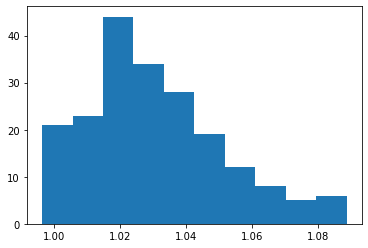

In [6]:
plt.hist(diffs['mc'])
plt.show()
plt.hist(diffs['cmps'])

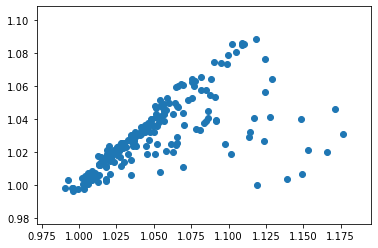

In [7]:
plt.scatter('mc', 'cmps', data = diffs)

### Expected $\sqrt n$ Random Runs

Again, but with runs filled with

In [20]:
n = 10000
reps = 200
sqrtn = int(n ** 0.5)

import sortstats.runs as runs

RNG = random.Random(2348905734)

def same_runs_descending(lst):
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_asc_runs_deterministic(lst, run_lens, 1)
    return lst


diffs = differences(reps, lambda: same_runs_descending(Inputs.random_runs(n, sqrtn, RNG)))
# print(diffs)
print(diffs['mc']  .describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))
print(diffs['cmps'].describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))

[(0, 4, True), (4, 6, False), (6, 11, True), (11, 14, False), (14, 16, False)]
[4, 2, 5, 3, 2]
count    200.000000
mean       1.050975
std        0.037926
min        0.990703
1%         0.995265
5%         1.003763
10%        1.010229
25%        1.021294
50%        1.044302
75%        1.069432
max        1.176370
Name: mc, dtype: float64
count    200.000000
mean       0.999077
std        0.005172
min        0.980672
1%         0.986125
5%         0.991929
10%        0.993534
25%        0.996063
50%        0.998317
75%        1.002422
max        1.022445
Name: cmps, dtype: float64


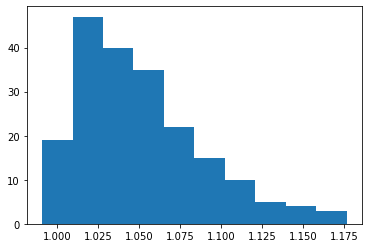

(array([ 1.,  3., 14., 65., 59., 40., 13.,  3.,  1.,  1.]),
 array([0.98067238, 0.98484961, 0.98902683, 0.99320405, 0.99738127,
        1.00155849, 1.00573572, 1.00991294, 1.01409016, 1.01826738,
        1.0224446 ]),
 <a list of 10 Patch objects>)

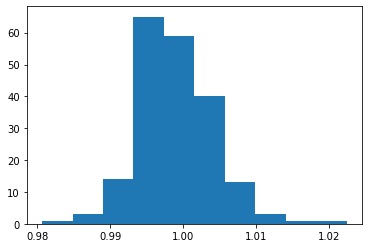

In [21]:
plt.hist(diffs['mc'])
plt.show()
plt.hist(diffs['cmps'])

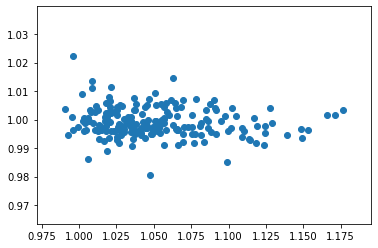

In [22]:
plt.scatter('mc', 'cmps', data = diffs)
